In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Função que gera as coordenadas dos APs
def distribuir_APs(M):
    if M not in [1, 4, 9, 16, 25, 36, 49, 64, 100]:
        return None

    tamanho_quadrado = 1000
    lado_quadrado = int(np.sqrt(M))

    tamanho_celula = tamanho_quadrado // lado_quadrado

    # Criar coordenadas usando meshgrid
    x, y = np.meshgrid(np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula),
                      np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula))

    coordenadas_APs = np.column_stack((x.ravel(), y.ravel()))

    return coordenadas_APs

In [22]:
# Função que gera a distância entre a UE e a AP
def distance_AP_UE(x_coord, y_coord, M):
  dAPUE = np.linalg.norm(np.array([x_coord, y_coord]) - M)
  return dAPUE

In [23]:
def find_shadowing(passos):
    shadowing = []

    valor_atual = np.random.lognormal(0, 2)  # Inicializa o shadowing com sigma = 2 [LINEAR]
    for i in range(passos):
        if (i) % 10 == 0 and i != 0:  # Atualiza o shadowing a cada 10 passos, exceto no passo 0
            valor_atual = np.random.lognormal(0, 2)
        shadowing.append(valor_atual)  # Adiciona o valor atual à lista
    return shadowing

In [24]:
# Função que calcula o path gain
def find_path_gain(dist, shadowing):
    k = 1e-4
    n = 4
    path_gain_result = shadowing * (k / ((dist) ** n)) #Obtem o path_gain local de cada AP

    return path_gain_result # [LINEAR]

In [25]:
# Função que calcula a potência recebida
def find_pot_rec(pot_trans, dist, d_0, shadowing):
    k = 1e-4
    n = 4
    if dist >= d_0:
        pot_rec_result = shadowing * (pot_trans * (k / ((dist) ** n))) #Obtem a potência recebida de cada AP

    return pot_rec_result # [LINEAR]

In [26]:
def calculate_snr(B_t, p_t, d_0, K_0, M, N, passos, shadowing):

    #UE irá se mover metro por metro e irá iniciar do ponto (0, 500) e irá até (1000, 500)
    x_coord = np.zeros(passos)
    y_coord = np.zeros(passos)
    for passo in range (passos):
        x_coord[passo] = (passo+1)
        y_coord[passo] = 500 

    #Definindo váriaveis locais
    ap_coord = distribuir_APs(M)
    power_noise = K_0*(B_t/N)
    distance = np.zeros(M)
    path_gain = np.zeros(M)
    power_rec = np.zeros(passos)
    snr = np.zeros(passos)

    #Fazendo o Handover
    for passo in range(passos):
        for index_AP in range(M):
            distance[index_AP] = distance_AP_UE(x_coord[passo], y_coord[passo], ap_coord[index_AP])
            path_gain[index_AP] = find_path_gain(distance[index_AP], shadowing[passo])
        max_index = np.argmax(path_gain)
        power_rec[passo] = find_pot_rec(p_t, distance[max_index], d_0, shadowing[passo])
        snr[passo] = power_rec[passo]/power_noise
    return snr

In [27]:
def calculate_capacity(B_t, p_t, d_0, K, M, N, passos, shadowing):
    snr = calculate_snr(B_t, p_t, d_0, K, M, N, passos, shadowing)
    b_c = B_t/N
    capacity = b_c * np.log2(1 + snr)
    return capacity

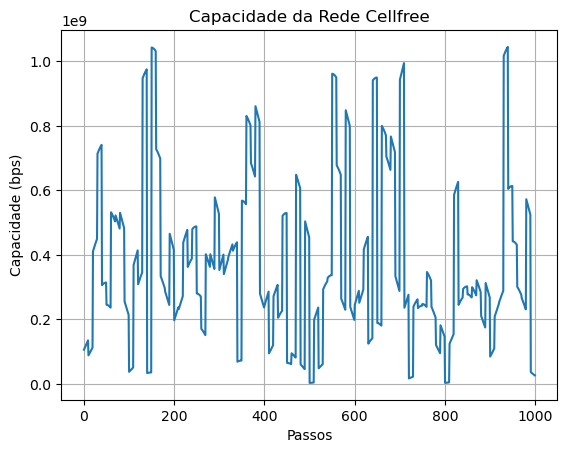

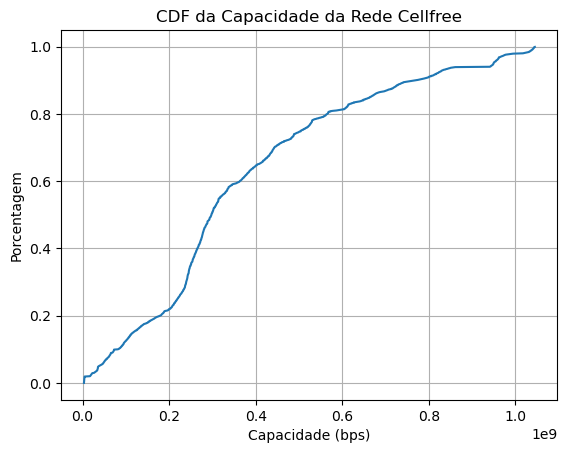

In [28]:
B_t, p_t, d_0, K_0 = 100e6, 1e3, 1, 1e-17 # Em MHz, mW, metros, mW/Hz respectivamente
ap, ue, channel = 100, 1, 1
passos = 1000
shadowing = find_shadowing(passos)
snr = calculate_snr(B_t, p_t, d_0, K_0, ap, channel, passos, shadowing)
capacity = calculate_capacity(B_t, p_t, d_0, K_0, ap, ue, passos, shadowing)
passos_array = np.arange(passos)
cdf_capacity = np.sort(capacity)

# Plotando a Capacidade pela distância percorrida
plt.plot(passos_array, capacity)
plt.xlabel('Passos')
plt.ylabel('Capacidade (bps)')
plt.title('Capacidade da Rede Cellfree')
plt.grid()
plt.show()

# Plotando a CDF da Capacidade
plt.plot(cdf_capacity, np.arange(0, len(capacity)) / len(capacity))
plt.xlabel('Capacidade (bps)')
plt.ylabel('Porcentagem')
plt.title('CDF da Capacidade da Rede Cellfree')
plt.grid()
plt.show()

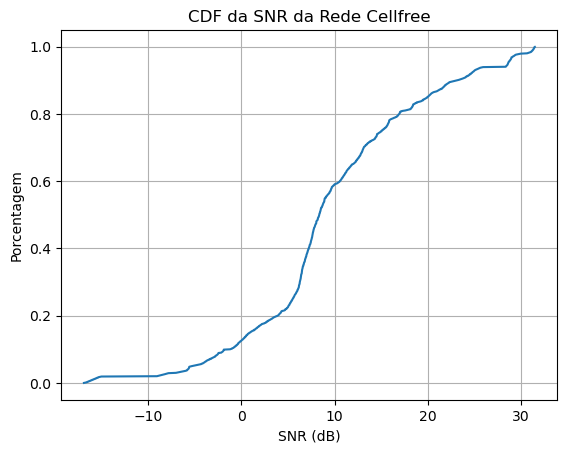

In [29]:
snr_db = 10*np.log10(snr)
cdf_snr = np.sort(snr_db)

# Plotando a CDF da SNR
plt.plot(cdf_snr, np.arange(0, len(capacity)) / len(capacity))
plt.xlabel('SNR (dB)')
plt.ylabel('Porcentagem')
plt.title('CDF da SNR da Rede Cellfree')
plt.grid()
plt.show()